# Identify nuclei according to a signal intensity

A common bio-image analysis task is differentiating cells according to their signal expression. In this example we take a two-channel image of nuclei which express `Cy3` and `eGFP`. This notebook demonstrates how to differentiate nuclei segmented in one channel according to the intensity in the other channel.

This example data was first published in [Heriche et. al.](https://doi.org/10.1091/mbc.E13-04-0221) and the original data is available [here](https://idr.openmicroscopy.org/webclient/img_detail/179719/).

In [1]:
import pyclesperanto as cle
import numpy as np
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import pandas as pd

cle.select_device(1, "gpu")

(OpenCL) Apple M2 Max (OpenCL 1.2 )
	Vendor:                      Apple
	Driver Version:              1.2 1.0
	Device Type:                 GPU
	Compute Units:               30
	Global Memory Size:          21845 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         4096 MB
	Max Clock Frequency:         1000 MHz
	Image Support:               Yes

We start by opening and displaying the example image.

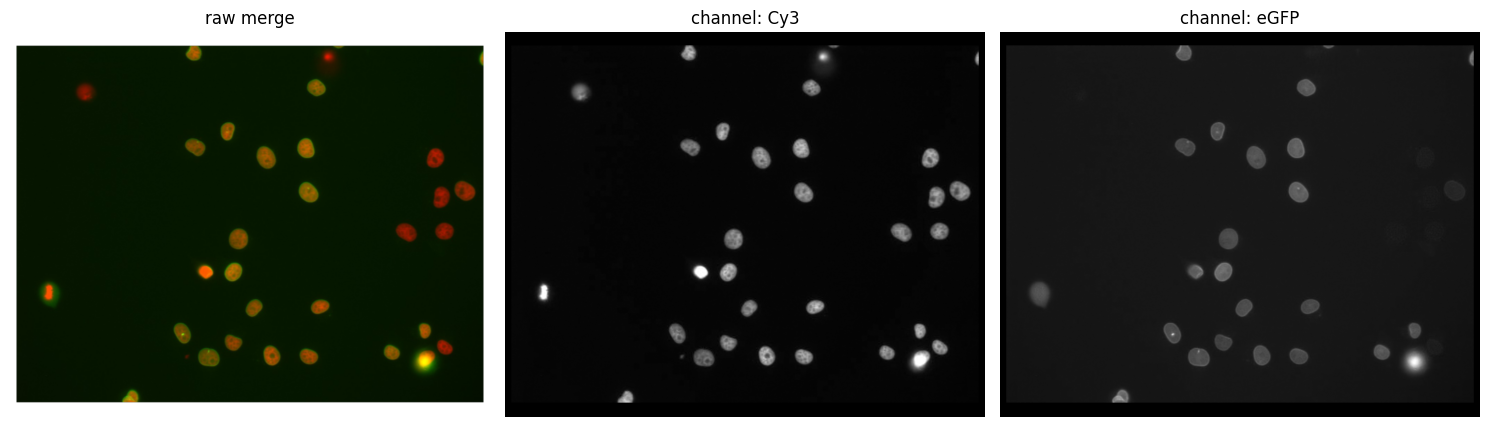

In [2]:
image = imread("../data/plate1_1_013 [Well 5, Field 1 (Spot 5)].png")
fig, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(image)
axs[0].set_title("raw merge")
axs[1].imshow(image[...,0], cmap="gray")
axs[1].set_title("channel: Cy3")
axs[2].imshow(image[...,1], cmap="gray")
axs[2].set_title("channel: eGFP")
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

## Segment the nuclei

As the staining marks the nuclei in the Cy3 channel, it is reasonable to segment nuclei in this channel and afterwards measure the intensity in the other channel. For that we use the function [Voronoi-Otsu-Labeling]("./voronoi_otsu_labeling.ipynb) for the segmentation as it is a quick and straightforward approach for this usecase.

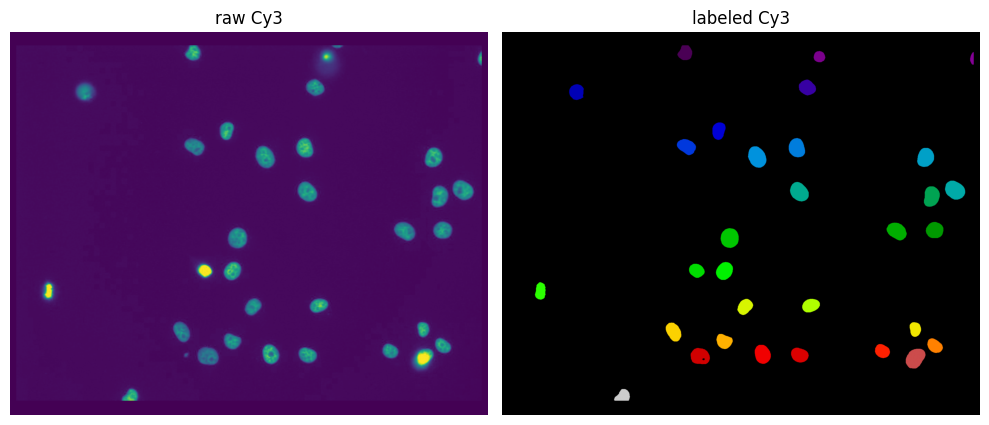

In [3]:
labeled_nuclei = cle.voronoi_otsu_labeling(image[...,0], spot_sigma=20, outline_sigma=1)

fig, axs = plt.subplots(1,2, figsize=(10,7))
axs[0].imshow(image[...,0])
axs[0].set_title("raw Cy3")
axs[1].imshow(labeled_nuclei, cmap="nipy_spectral")
axs[1].set_title("labeled Cy3")
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

Now that we have all the nuclei segmented, we can measure the intensity in the second channel, marked with eGFP and visualize that measurement in a parametric image. In such a parametric image, all pixels inside a nucleus have the same value of interest. In this case we are plotting the mean average intensity of each nuclei.

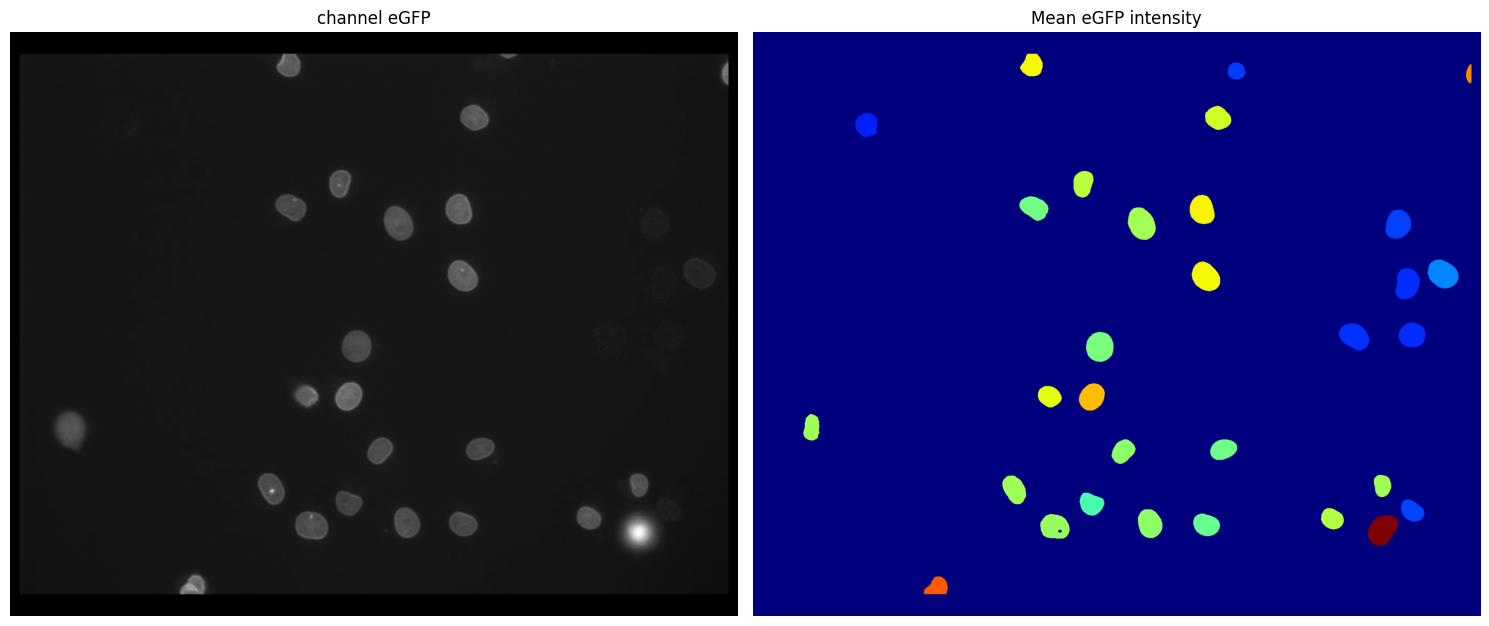

In [4]:
avg_intensity_map = cle.mean_intensity_map(image[...,1], labeled_nuclei)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(image[...,1], cmap="gray")
axs[0].set_title("channel eGFP")
axs[1].imshow(avg_intensity_map, cmap="jet")
axs[1].set_title("Mean eGFP intensity")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

We can also retrieve the intensity value into an array. The first entry in such array will corresponds to the intensity of the background, which is 0 in the parametric image.

In [5]:
intensity_vector = cle.read_map_values(avg_intensity_map, labeled_nuclei)
intensity_vector

AttributeError: module 'pyclesperanto' has no attribute 'read_map_values'

We can plot the distribution of the mean intensity using the histogram plot from matplotlib to plot a histogram. We ignore the first element, because it corresponds to the background intensity. From this quick plot, we can easily conclude that our data contain above 50 positive nuclei for our marker of interest.

## Selecting labels above a given intensity threshold

We have our nuclei label map and we now known a good average intensity threshold do isolate our signal of interest. We this we can filter the label map to only keep the target nuclei. While all the above steps for extracting the intensity vector are not necessary for this, it was a relevant process in order to get a good intensity threshold value.

Once filtered, we get the amount of nuclei maked by Cy5 that express eGFP signal.

In [ ]:
intensity_threshold = 50
nuclei_of_interest = cle.remove_labels_with_map_values_within_range(avg_intensity_map, labeled_nuclei, maximum_value_range=intensity_threshold)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(image[...,1], cmap="gray")
axs[0].set_title("channel eGFP")
axs[1].imshow(nuclei_of_interest, cmap="nipy_spectral")
axs[1].set_title(f"{nuclei_of_interest.max()} Cy3 nuclei expressing eGFP > {intensity_threshold}")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()